### GPT2 loading

In [3]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch
from torch.utils.data import Dataset
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config
from datasets import load_dataset
import math
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

2025-09-27 12:11:59.715785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758975119.887604      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758975119.939640      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.load_state_dict(torch.load("/kaggle/working/gpt2_ntp.pth"))

tokenizer.pad_token = tokenizer.eos_token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  

print("Model loaded successfully!")

Model loaded successfully!


In [31]:
prompt = "The movie we watched was"
inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
with torch.no_grad():
        outputs = model(inputs)
        predictions = outputs.logits
        
        next_token_logits = predictions[0, -1, :]
        
        next_token_id = torch.argmax(next_token_logits).item()
    
        next_token = tokenizer.decode(next_token_id)

print(f"Prompt: '{prompt}'")
print(f"Next token: '{next_token}'")
print(f"Full text: '{prompt}{next_token}'")

Prompt: 'The movie we watched was'
Next token: ' called'
Full text: 'The movie we watched was called'


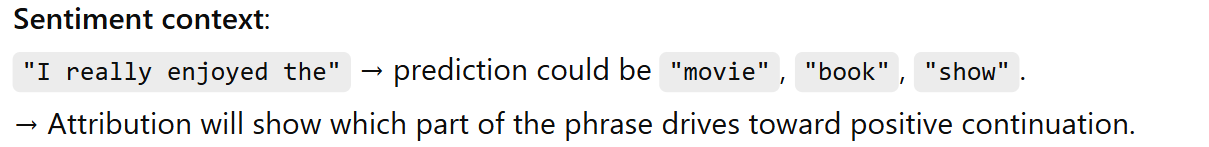

//to go with different phrases for different contexts (reasoning /sentiment ect)

## does doing ig for ntp make sense as a concept?

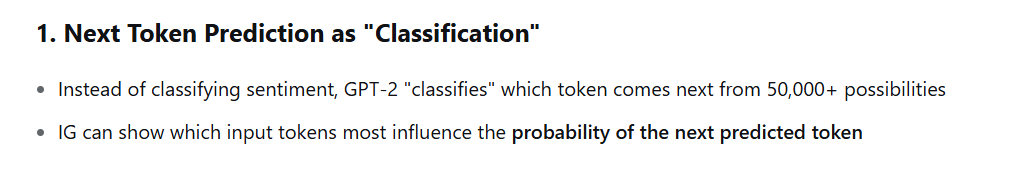

In [30]:
def integrated_gradients_gpt2(model, tokenizer, prompt, target_token=None, steps=50):
    """
    Integrated Gradients for GPT-2 next token prediction
    """
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    
    # we get embeddings
    embeddings = model.transformer.wte(inputs)  # GPT-2 uses wte for word token embeddings
    
    # baseline
    baseline = torch.zeros_like(embeddings)
    
    # target tokens ?
    with torch.no_grad():
        outputs = model(inputs)
        next_token_logits = outputs.logits[0, -1, :]
        if target_token is None:
            target_token_id = torch.argmax(next_token_logits).item()
        else:
            target_token_id = tokenizer.encode(target_token)[0]
    
    #interpolation
    scales = torch.linspace(0, 1, steps).to(device)
    
    # store gradients
    total_gradients = torch.zeros_like(embeddings)
    
    for i, scale in enumerate(scales):
        model.zero_grad()
        
        # interpolate between baseline and actual input
        interpolated = baseline + scale * (embeddings - baseline)
        interpolated.requires_grad_(True)
        interpolated.retain_grad() 
        
                
        # forward pass
        outputs = model(inputs_embeds=interpolated)
        next_token_logits = outputs.logits[0, -1, :]
        target_prob = torch.softmax(next_token_logits, dim=-1)[target_token_id]
        
        # backward pass 
        target_prob.backward(retain_graph=True)
        
#accumulate the gradients
        if interpolated.grad is not None:
            total_gradients += interpolated.grad.detach() / steps

    
    # average gradients
    avg_gradients = total_gradients

    
    # integrated Gradients 
    integrated_grads = (embeddings - baseline) * avg_gradients
    
    # sum across embedding dimension to get token importance
    token_importance = integrated_grads.sum(dim=-1).squeeze(0)
    
    return token_importance.detach().cpu().numpy(), target_token_id



In [27]:
def explain_gpt2_prediction(prompt, target_token=None):
    """
    Explain GPT-2's next token prediction using Integrated Gradients
    """
    print("=" * 60)
    print(f"Analyzing prompt: '{prompt}'")
    
    # get importance scores
    importance_scores, target_token_id = integrated_gradients_gpt2(
        model, tokenizer, prompt, target_token
    )
    
    # get tokens
    input_ids = tokenizer.encode(prompt)
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    target_word = tokenizer.decode([target_token_id])
    
    print(f"Predicted next token: '{target_word}' (id: {target_token_id})")
    print("\nToken importance scores:")
    print("-" * 40)
    
    for i, (token, score) in enumerate(zip(tokens, importance_scores)):
        print(f"{i:2d}. {token:15} {score:12.6f}")
    
    # simple visualization
    print("\nVisualization (green=positive, red=negative influence):")
    colored_output = ""
    for token, score in zip(tokens, importance_scores):
        if score > 0.01:
            colored_output += f"\033[92m{token}\033[0m "  
        elif score < -0.01:
            colored_output += f"\033[91m{token}\033[0m "  
        else:
            colored_output += f"{token} "
    print(colored_output)
    
    return importance_scores, tokens, target_word

In [32]:
test_prompts = [
        "The weather today is",
        "I want to eat",
        "She loves to read",
        "The capital of France is",
        "This movie is"
    ]
    
for prompt in test_prompts:
    scores, tokens, target = explain_gpt2_prediction(prompt)


Analyzing prompt: 'The weather today is'
Predicted next token: ' not' (id: 407)

Token importance scores:
----------------------------------------
 0. The                -0.001190
 1. Ġweather            0.035220
 2. Ġtoday              0.015848
 3. Ġis                -0.008573

Visualization (green=positive, red=negative influence):
The Ġweather Ġtoday Ġis 
Analyzing prompt: 'I want to eat'
Predicted next token: ' more' (id: 517)

Token importance scores:
----------------------------------------
 0. I                   0.018265
 1. Ġwant               0.056652
 2. Ġto                -0.003781
 3. Ġeat                0.004025

Visualization (green=positive, red=negative influence):
I Ġwant Ġto Ġeat 
Analyzing prompt: 'She loves to read'
Predicted next token: ' and' (id: 290)

Token importance scores:
----------------------------------------
 0. She                 0.102358
 1. Ġloves              0.217135
 2. Ġto                -0.068377
 3. Ġread              -0.000535

Visualization 

In [33]:


def plot_token_importance(tokens, scores):
    plt.figure(figsize=(12,2))
    norm = np.max(np.abs(scores))
    colors = [plt.cm.bwr((s/norm + 1)/2) for s in scores]  # blue=neg, red=pos

    for i, (tok, score) in enumerate(zip(tokens, scores)):
        plt.text(i, 0.5, tok, rotation=90,
                 ha="center", va="center",
                 bbox=dict(facecolor=colors[i], alpha=0.8, boxstyle="round,pad=0.3"))

    plt.axis("off")
    plt.show()


Analyzing prompt: 'The capital of France is'
Predicted next token: ' the' (id: 262)

Token importance scores:
----------------------------------------
 0. The                -0.063149
 1. Ġcapital            0.237535
 2. Ġof                -0.028016
 3. ĠFrance             0.092263
 4. Ġis                 0.222707

Visualization (green=positive, red=negative influence):
The Ġcapital Ġof ĠFrance Ġis 


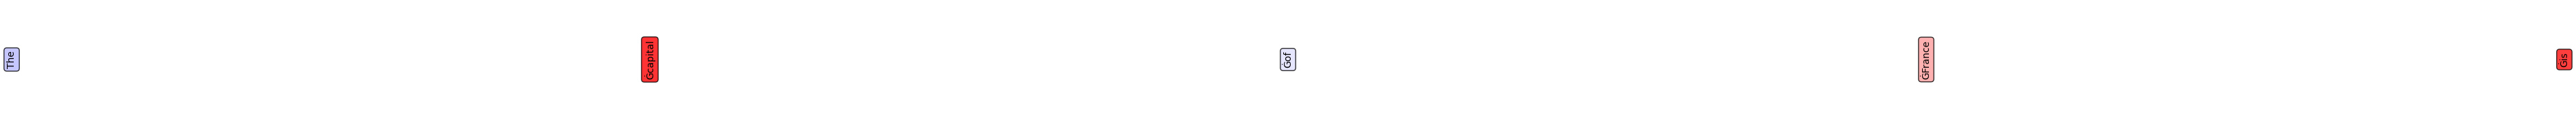

In [34]:
scores, tokens, target = explain_gpt2_prediction("The capital of France is")
plot_token_importance(tokens, scores)


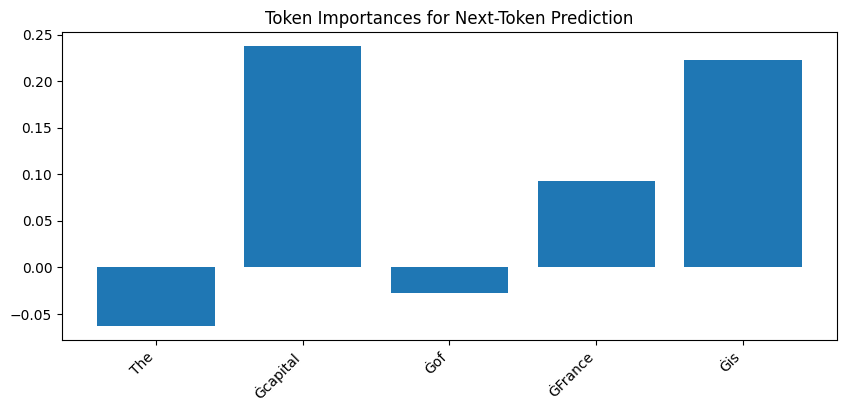

In [35]:
def barplot_importance(tokens, scores):
    plt.figure(figsize=(10,4))
    plt.bar(range(len(tokens)), scores)
    plt.xticks(range(len(tokens)), tokens, rotation=45, ha="right")
    plt.title("Token Importances for Next-Token Prediction")
    plt.show()
barplot_importance(tokens, scores)

In [ ]:
## to changeeeeeeeeeeeeeee why is it generating wrong wordssssssssssssssssssssssssss